targets.shape=(36, 2)


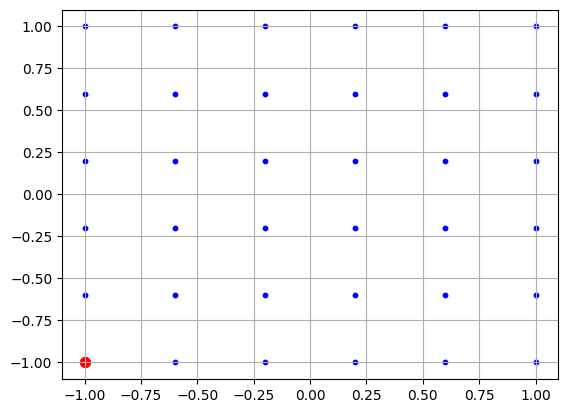

In [12]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(3)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(6)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# Offset one a bit
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1],
# ])
# print(f"{depots=}")
depot_indices_temp = range(len(targets), len(targets)+len(depots))

# depots = np.concatenate((depots, depots))


# Chose starting depot node
# Make all robots start from same depot
# B_k = np.array([depot_indices_temp[0]] * k)
# Make depots start from multiple depots
B_k = depot_indices_temp[:k]
# print(f"{B_k=}")

# Make sure the starting depots are duplicated.
# This is needed s.t. robots can go back to recharge at the same location multiple times.
# If this is not done, the robot can't keep recharging at the depot it starts and ends at.
unique_start_depots = []
for b_k in B_k:
    if b_k not in unique_start_depots:
        unique_start_depots.append(b_k)
for b_k in unique_start_depots:
    depots = np.concatenate((depots, np.array([depots[b_k-len(target_indices)]])))

depot_indices = range(len(targets), len(targets)+len(depots))
# print(f"{depots=}")

nodes = np.concatenate((targets, depots))
node_indices = range(len(targets)+len(depots))
# print(f"{nodes.shape=}")

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [13]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(38, 38)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for ki in range(k):
    for i in target_indices:
        for j in target_indices:
            if i == j: continue
            _ = m.addConstr(x[ki,i,j] <= 1)
        for j in depot_indices:
            _ = m.addConstr(x[ki,i,j] <= 1)
            _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685


GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)

In [ ]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == 1 for i in target_indices)

for ki in range(k):
    _ = m.addConstrs(x[ki,i,:].sum() <= 1 for i in target_indices)
    _ = m.addConstrs(x[ki,:,i].sum() <= 1 for i in target_indices)

    # (8) and (9) Begin and end at same position B_k
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)
    
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes! This is needed because we ignore the i != j constraint in others
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [ ]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)
    
    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [ ]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 4.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [ ]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [ ]:
import datetime


def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)
        
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

In [ ]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
                
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            # If this solution's maximum costing tour ~= the cost of tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


In [ ]:
m._x = x
solver = MILPSolver(m)
solver.solve()

In [ ]:
visualize_paths_brute_force(MILPSolver.min_cost_edges)
# visualize_paths_faster(MILPSolver.min_cost_edges)